## Churn Prediction using AMLWorkbench

This notebook will introduce the use of the churn dataset to create churn prediction models. The dataset used to ingest is from SIDKDD 2009 competition. The dataset consists of heterogeneous noisy data (numerical/categorical variables) from French Telecom company Orange and is anonymized.

We will use the .dprep file created from the datasource wizard.

In [2]:
import dataprep
from dataprep.Package import Package
import pickle

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import csv
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

C:\Users\mikher\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read Data

We first retrieve the data as a data frame using .dprep that we created using the datasource wizard. Print the top few lines using head()

In [3]:
#Local via package
with Package.open_package('CATelcoCustomerChurnTrainingSample.dprep') as pkg:
    df = pkg.dataflows[0].get_dataframe()

# Blob via package
#with Package.open_package('CATelcoCustomerChurnTrainingBlobSample.dprep') as pkg:
#    df = pkg.dataflows[0].get_dataframe()
    
# if this one fails check to see that you are NOT exporting file to local/blob
# storage because it will fail to overwrite

# Local via CSV file
# df = pd.read_csv("./data/CATelcoCustomerChurnTrainingSample.csv")
df.head(5)

,age,age_bin,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,...,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn
0,12.0,0-19,168147.0,0.06,0.00,4.251078e+09,1.0,Yes,Bachelor or equivalent,Male,...,371.0,WA,15.0,19.0,No,No,0.82,5971.0,663.0,0.0
1,12.0,0-19,168147.0,0.06,0.00,4.251078e+09,1.0,Yes,Bachelor or equivalent,Male,...,371.0,WA,15.0,19.0,No,No,0.82,3981.0,995.0,0.0
2,42.0,40-59,29047.0,0.05,0.01,4.251043e+09,2.0,Yes,Bachelor or equivalent,Female,...,43.0,WI,212.0,34.0,No,Yes,0.27,7379.0,737.0,0.0
3,42.0,40-59,29047.0,0.05,0.01,4.251043e+09,2.0,Yes,Bachelor or equivalent,Female,...,43.0,WI,212.0,34.0,No,Yes,0.27,1729.0,432.0,0.0
4,58.0,40-59,27076.0,0.07,0.02,4.251056e+09,3.0,Yes,Master or equivalent,Female,...,403.0,KS,216.0,144.0,No,No,0.48,3122.0,624.0,0.0


In [6]:
df.columns.get_loc("churn")

27

## Encode Columns

Convert categorical variable into dummy/indicator variables using pandas.get_dummies. In addition, we will need to change the column names to ensure there are no multiple columns with the same name 

In [7]:
columns_to_encode = list(df.select_dtypes(include=['category','object']))
print(columns_to_encode)
for column_to_encode in columns_to_encode:
    dummies = pd.get_dummies(df[column_to_encode])
    one_hot_col_names = []
    for col_name in list(dummies.columns):
        one_hot_col_names.append(column_to_encode + '_' + col_name)
    dummies.columns = one_hot_col_names
    df = df.drop(column_to_encode, axis=1)
    df = df.join(dummies)

print("Encoded columns:")
print(df.columns)

['age_bin', 'customersuspended', 'education', 'gender', 'homeowner', 'maritalstatus', 'noadditionallines', 'occupation', 'state', 'usesinternetservice', 'usesvoiceservice']
Encoded columns:
Index(['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum',
       'customerid', 'monthlybilledamount', 'numberofcomplaints',
       'numberofmonthunpaid', 'numdayscontractequipmentplanexpiring',
       'penaltytoswitch', 'totalminsusedinlastmonth', 'unpaidbalance',
       'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration',
       'churn', 'age_bin_0-19', 'age_bin_0-39', 'age_bin_20-39',
       'age_bin_20-59', 'age_bin_40-59', 'age_bin_40-79', 'age_bin_60-79',
       'age_bin_60-99', 'customersuspended_No', 'customersuspended_Yes',
       'education_Bachelor or equivalent', 'education_High School or below',
       'education_Master or equivalent', 'education_PhD or equivalent',
       'gender_Female', 'gender_Male', 'homeowner_No', 'homeowner_Yes',
       'mar

## Modeling

First, we will build a Gaussian Naive Bayes model using GaussianNB for churn classification. Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes theorem with the “naive” assumption of independence between every pair of features.

In addition, we will also build a decision tree classifier for comparison:

- min_samples_split=20 requires 20 samples in a node for it to be split
- random_state=99 to seed the random number generator

## Investigate important features
Not all features might be important. Try to find the features that influence the most

In [8]:
from sklearn.ensemble import ExtraTreesClassifier

train, test = train_test_split(df, test_size = 0.3, random_state=98)
Y = train['churn'].values
X = train.drop('churn', 1)
X = X.values

model_feature_test = ExtraTreesClassifier()
model_feature_test.fit(X, Y)
features_ranked = model_feature_test.feature_importances_
print("Feature importance:\n" + str(features_ranked))

#>>> a
#array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
ind = np.argpartition(features_ranked, -20)[-20:]
print("Top Feature Index:\n" + str(ind))
#array([1, 5, 8, 0])
print(features_ranked[ind])

top_feature_names = train.columns[ind]
print("Top feature names:\n" + str(top_feature_names))
#array([4, 9, 6, 9])

#Unlike argsort, this function runs in linear time in the worst case, but the returned indices are not sorted, as can be seen from the result of evaluating a[ind]. If you need that too, sort them afterwards:

#>>> ind[np.argsort(a[ind])]
#array([1, 8, 5, 0])


#sorted_features = sorted(range(len(features_ranked)), 
#                         key=lambda i: features_ranked[i], reverse=True) 

Feature importance:
[ 0.04340271  0.03329     0.03131     0.02643166  0.03026955  0.03660749
  0.03178325  0.03296814  0.03556194  0.03019857  0.0318298   0.0345027
  0.03442636  0.03566538  0.01487963  0.01486395  0.00616458  0.00247304
  0.01194481  0.00347185  0.00949989  0.00189284  0.00538797  0.00098644
  0.00395453  0.00274463  0.01282327  0.01679431  0.00730319  0.00888509
  0.01623254  0.01673482  0.0114993   0.01075696  0.01436163  0.01211747
  0.          0.01667111  0.01918912  0.01708947  0.007547    0.00288706
  0.00440441  0.00444043  0.0095549   0.00783736  0.00356215  0.00577072
  0.00597484  0.00183501  0.0075279   0.00528927  0.00358517  0.00370574
  0.00436506  0.00582198  0.00553677  0.0035362   0.00619003  0.00319907
  0.00520466  0.00403992  0.0034528   0.00730805  0.00300461  0.00702608
  0.00624394  0.00568189  0.00238585  0.00868123  0.00312267  0.00238359
  0.00505988  0.00787644  0.00696098  0.00365547  0.00408767  0.00656146
  0.00341981  0.00637471  0.0059

In [9]:
df.columns.get_loc("churn")

16

In [10]:
len(df.columns)

95

## Train on only top features

In [11]:
top_feature_names

Index(['education_PhD or equivalent', 'noadditionallines_\N', 'gender_Female',
       'education_Bachelor or equivalent',
       'occupation_Non-technology Related Job', 'occupation_Others',
       'callfailurerate', 'numdayscontractequipmentplanexpiring',
       'calldroprate', 'callingnum', 'monthlybilledamount', 'penaltytoswitch',
       'numberofcomplaints', 'annualincome', 'numberofmonthunpaid',
       'customerid', 'totalminsusedinlastmonth', 'unpaidbalance',
       'percentagecalloutsidenetwork', 'age'],
      dtype='object')

### Naive Bayes model

In [12]:
model = GaussianNB()

# top_feature_names.append(['churn'])
dfChurn = df[['churn']]
dfFeatures = df[top_feature_names]
dfTopFeaturesChurn = dfFeatures.join(dfChurn)

train, test = train_test_split(dfTopFeaturesChurn, test_size = 0.3, random_state=98)

target = train['churn'].values
train = train.drop('churn', 1)
train = train.values
model.fit(train, target)

Y_test_val = test['churn'].values
X_test_val = test.drop('churn', 1).values
predicted = model.predict(X_test_val)
print("Naive Bayes Classification Accuracy", accuracy_score(Y_test_val, predicted))

Naive Bayes Classification Accuracy 0.889666666667


In [13]:
print("#Expected churn: " + str(sum(Y_test_val[Y_test_val[:] > 0])))
print("#Predcited churn: " + str(sum(predicted[predicted[:] > 0])))

#Expected churn: 286.0
#Predcited churn: 53.0


In [14]:
exp_inp = pd.Categorical(Y_test_val, categories=[0,1])
pred_inp = pd.Categorical(predicted, categories=[0,1])
print(pd.crosstab(exp_inp, pred_inp, colnames=["Predicted"], rownames=['Actual']))

Predicted     0   1
Actual             
0          2665  49
1           282   4


### ROC Curve Naive Bayes

AUC:0.505733028946


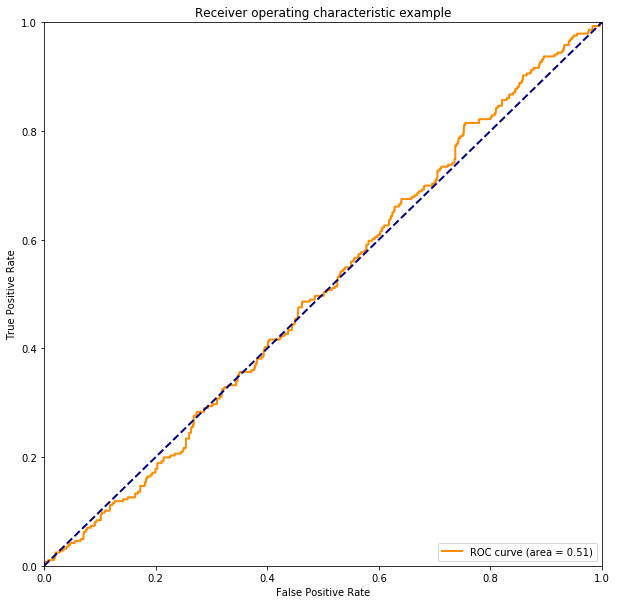

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_prob = model.predict_proba(X_test_val)
# TASK: Rita ROC curve
# confidence_nb = predicted_prob.max(axis=1)
fpr, tpr, thresholds = roc_curve(Y_test_val, predicted_prob[:, 1])
roc_auc_nb = roc_auc_score(Y_test_val, predicted_prob[:, 1])
print("AUC:" + str(roc_auc_nb))

plt.figure(figsize=(10,10))
plt.title('Receiver operating characteristic example')
plt.plot(fpr, tpr, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Precision and recall
High recall means that we manage to pick most of the positive examples (churn)
Low precision means that we also pick a lot of false positive for the churn which
means that a high recall and a low precision catches most of the true churn at the
cost of getting many false churn at the same time. Low precision = not so precise

See: https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 for a good explanation.

The chart below calculates the precision and recall for the different thresholds of the probability of our predicions.

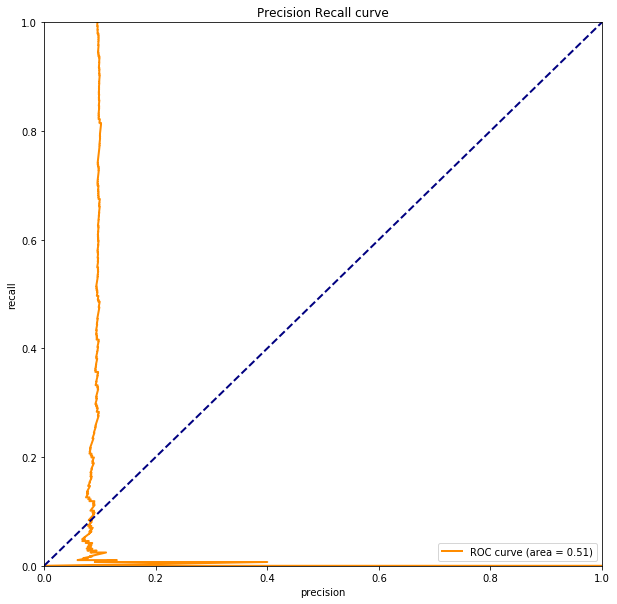

Precision:
[ 0.09568418  0.09507867  0.09511052 ...,  0.          0.          1.        ]
Recall:
[ 1.          0.99300699  0.99300699 ...,  0.          0.          0.        ]

If we want to catch every churn the precision would be only 9.57%
I.e. we would catch a huge number of false positive at the same time.
The other way around. If we want only True positive churn (no false) we would get a recall of 99.30%
Depending of the business case you can chose different thresholds


In [16]:
precision, recall, thresholds_pr = precision_recall_curve(Y_test_val, predicted_prob[:,1])
plt.figure(figsize=(10,10))
plt.title('Precision Recall curve')
plt.plot(precision, recall, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()
print("Precision:\n" + str(precision))
print("Recall:\n" + str(recall))

print("\nIf we want to catch every churn the precision would be only " + "{:.2%}".format(precision[0]))
print("I.e. we would catch a huge number of false positive at the same time.")
print("The other way around. If we want only True positive churn (no false) we would get a recall of " + "{:.2%}".format(recall[6]))
print("Depending of the business case you can chose different thresholds")


### Tree model

In [17]:
help(ExtraTreesClassifier)

Help on class ExtraTreesClassifier in module sklearn.ensemble.forest:

class ExtraTreesClassifier(ForestClassifier)
 |  An extra-trees classifier.
 |  
 |  This class implements a meta estimator that fits a number of
 |  randomized decision trees (a.k.a. extra-trees) on various sub-samples
 |  of the dataset and use averaging to improve the predictive accuracy
 |  and control over-fitting.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  max_features : int, float, string or None, optional (default="auto")
 |      The number of features to consider when looking for the best split:
 |  
 |      - If int, then consider `max_features` features

In [18]:
modelxt = ExtraTreesClassifier()
# modelxt = RandomForestClassifier()

# top_feature_names.append(['churn'])
dfChurn = df[['churn']]
dfFeatures = df[top_feature_names]
dfTopFeaturesChurn = dfFeatures.join(dfChurn)

train, test = train_test_split(dfTopFeaturesChurn, test_size = 0.3, random_state=98)

target = train['churn'].values
train = train.drop('churn', 1)
train = train.values
modelxt.fit(train, target)

Y_test_val = test['churn'].values
X_test_val = test.drop('churn', 1).values
predicted = modelxt.predict(X_test_val)
print("ExtraTreesClassifier acc:", accuracy_score(Y_test_val, predicted))

ExtraTreesClassifier acc: 0.978


#### Confusion matrix

In [19]:
print("#Expected churn: " + str(sum(Y_test_val[Y_test_val[:] > 0])))
print("#Predcited churn: " + str(sum(predicted[predicted[:] > 0])))

#Expected churn: 286.0
#Predcited churn: 220.0


In [20]:
exp_inp = pd.Categorical(Y_test_val, categories=[0,1])
pred_inp = pd.Categorical(predicted, categories=[0,1])
print(pd.crosstab(exp_inp, pred_inp, colnames=["Predicted"], rownames=['Actual']))

Predicted     0    1
Actual              
0          2714    0
1            66  220


####  Confusion matrix results example
    Predicted     0    1
    Actual              
    0          2708    4
    1            75  213

We predicted 2708+75 as non-churn<br>
We predicted 4 non-churn wrongly as churn<br>
We predicted 217 as churn (4 was non-churn of these)<br>
We did not catch 75 churn that was predcited as non-churn<br>


### ROC Curve ExtraTreesClassifier

AUC:0.945764942027


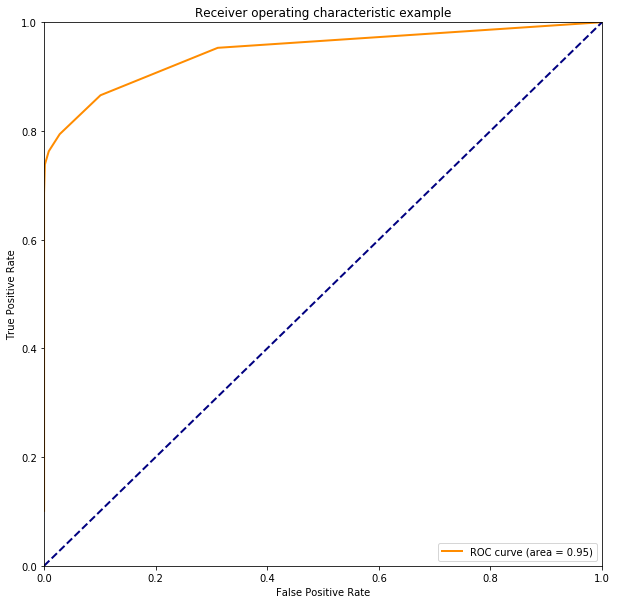

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
predicted_prob = modelxt.predict_proba(X_test_val)
# TASK: Rita ROC curve
# confidence_nb = predicted_prob.max(axis=1)
fpr, tpr, thresholds = roc_curve(Y_test_val, predicted_prob[:, 1])
roc_auc_nb = roc_auc_score(Y_test_val, predicted_prob[:, 1])
print("AUC:" + str(roc_auc_nb))

plt.figure(figsize=(10,10))
plt.title('Receiver operating characteristic example')
plt.plot(fpr, tpr, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Precision and recall
High recall means that we manage to pick most of the positive examples (churn)
Low precision means that we also pick a lot of false positive for the churn which
means that a high recall and a low precision catches most of the true churn at the
cost of getting many false churn at the same time. Low precision = not so precise

See: https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 for a good explanation.

The chart below calculates the precision and recall for the different thresholds of the probability of our predicions.

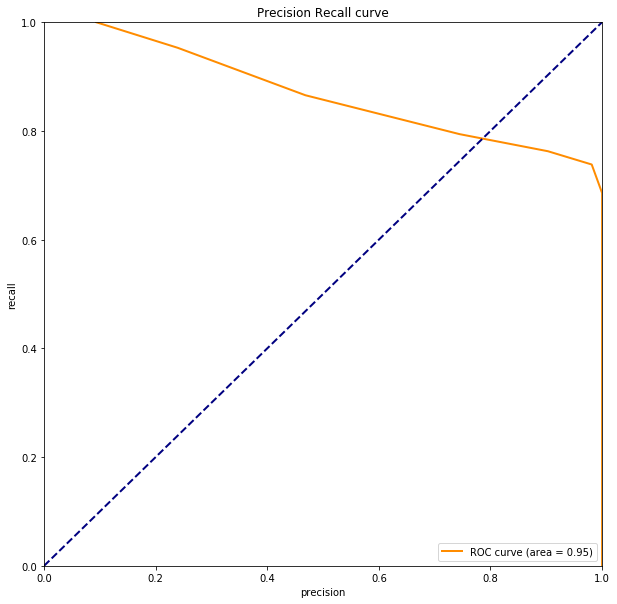

Precision:
[ 0.09330728  0.23957876  0.46836638  0.74468085  0.90289256  0.98143852
  1.          1.          1.          1.          1.          1.        ]
Recall:
[ 1.          0.95287958  0.86561955  0.79406632  0.76265271  0.7382199
  0.68586387  0.60732984  0.44502618  0.28097731  0.10122164  0.        ]

If we want to catch every churn the precision would be only 9.33%
I.e. we would catch a huge number of false positive at the same time.
The other way around. If we want only True positive churn (no false) we would get a recall of 68.59%
Depending of the business case you can chose different thresholds


In [31]:
precision, recall, thresholds_pr = precision_recall_curve(Y_test_val, predicted_prob[:,1])
plt.figure(figsize=(10,10))
plt.title('Precision Recall curve')
plt.plot(precision, recall, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()
print("Precision:\n" + str(precision))
print("Recall:\n" + str(recall))

print("\nIf we want to catch every churn the precision would be only " + "{:.2%}".format(precision[0]))
print("I.e. we would catch a huge number of false positive at the same time.")
print("The other way around. If we want only True positive churn (no false) we would get a recall of " + "{:.2%}".format(recall[6]))
print("Depending of the business case you can chose different thresholds")


In [94]:
dfTopFeaturesChurn.columns.get_loc("churn")

6

In [106]:
dfFeatures

,totalcallduration,education_Bachelor or equivalent,occupation_Others,noadditionallines_\N,avgcallduration,gender_Female,callfailurerate,annualincome,totalminsusedinlastmonth,calldroprate,numdayscontractequipmentplanexpiring,numberofmonthunpaid,numberofcomplaints,monthlybilledamount,callingnum,age,customerid,penaltytoswitch,unpaidbalance,percentagecalloutsidenetwork
0,5971.0,1,0,1,663.0,0,0.00,168147.0,15.0,0.06,96.0,7.0,0.0,71.0,4.251078e+09,12.0,1.0,371.0,19.0,0.82
1,3981.0,1,0,1,995.0,0,0.00,168147.0,15.0,0.06,96.0,7.0,0.0,71.0,4.251078e+09,12.0,1.0,371.0,19.0,0.82
2,7379.0,1,0,1,737.0,1,0.01,29047.0,212.0,0.05,14.0,4.0,1.0,8.0,4.251043e+09,42.0,2.0,43.0,34.0,0.27
3,1729.0,1,0,1,432.0,1,0.01,29047.0,212.0,0.05,14.0,4.0,1.0,8.0,4.251043e+09,42.0,2.0,43.0,34.0,0.27
4,3122.0,0,0,1,624.0,1,0.02,27076.0,216.0,0.07,55.0,2.0,0.0,16.0,4.251056e+09,58.0,3.0,403.0,144.0,0.48
5,2769.0,0,0,1,553.0,1,0.02,27076.0,216.0,0.07,55.0,2.0,0.0,16.0,4.251056e+09,58.0,3.0,403.0,144.0,0.48
6,834.0,0,0,1,834.0,0,0.03,137977.0,412.0,0.05,73.0,7.0,1.0,74.0,4.251042e+09,20.0,4.0,76.0,159.0,0.94
7,5868.0,0,0,1,838.0,0,0.03,137977.0,412.0,0.05,73.0,7.0,1.0,74.0,4.251042e+09,20.0,4.0,76.0,159.0,0.94
8,1886.0,0,0,1,628.0,0,0.00,136006.0,416.0,0.07,14.0,5.0,0.0,81.0,4.251073e+09,36.0,5.0,436.0,19.0,0.15
9,2602.0,0,0,1,867.0,0,0.00,136006.0,416.0,0.07,14.0,5.0,0.0,81.0,4.251073e+09,36.0,5.0,436.0,19.0,0.15


In [114]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=982)
dt.fit(train, target)
predicted = dt.predict(test)
print("Decision Tree Classification Accuracy", accuracy_score(expected, predicted))

Decision Tree Classification Accuracy 0.901666666667


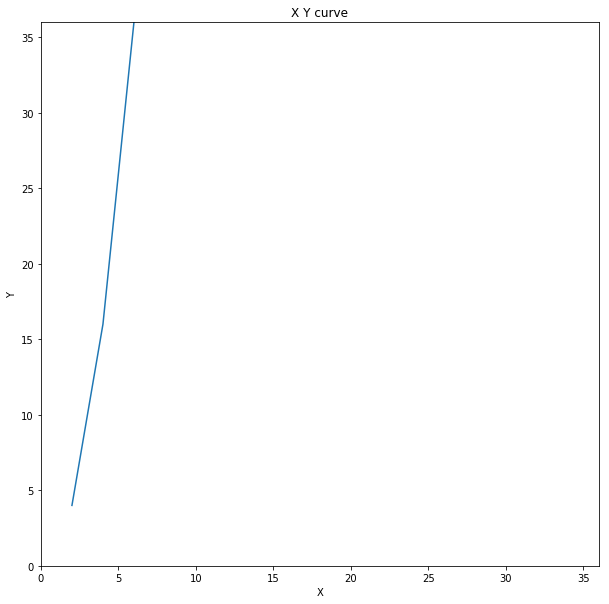

In [32]:
x = np.array([2, 4, 6])
y = np.array([4, 16, 36])

plt.figure(figsize=(10,10))
plt.title('X Y curve')
# plt.plot(precision, recall, color='darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.legend(loc="lower right")
plt.xlim([0.0, 36.0])
plt.ylim([0.0, 36.0])
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(x, y)
plt.show()
